# Import Package

In [54]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

from PIL import Image

import librosa # For feature extraction and wav file playback
import librosa.display 
import librosa.feature

import os 

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, RandomizedSearchCV 
from sklearn.ensemble import RandomForestClassifier # Random forest
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, zero_one_loss, classification_report 
from sklearn.preprocessing import normalize, StandardScaler

import tensorflow as tf # Pour le reseau de neurones simple et pour le CNN
from tensorflow import keras

import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.utils import to_categorical

from xgboost import XGBClassifier
from pprint import pprint

# Dataset pre-processing

In [2]:
Crema = "C:/Users/julia/Desktop/5A/FinalProject/AudioWAV/AudioWAV/"

In [3]:
crema_directory_list = os.listdir(Crema)

In [4]:
file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema+file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':  
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                               Path
0    angry  C:/Users/julia/Desktop/5A/FinalProject/AudioWA...
1  disgust  C:/Users/julia/Desktop/5A/FinalProject/AudioWA...
2     fear  C:/Users/julia/Desktop/5A/FinalProject/AudioWA...
3    happy  C:/Users/julia/Desktop/5A/FinalProject/AudioWA...
4  neutral  C:/Users/julia/Desktop/5A/FinalProject/AudioWA...

In [6]:
len(Crema_df)

7442

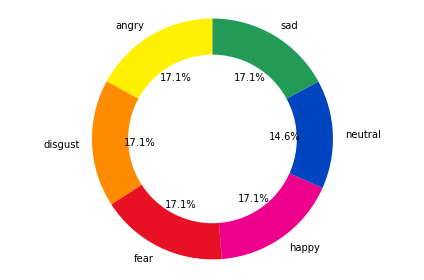

In [46]:
#Plot the distribution of classes 

y = Crema_df['Emotions']
values = np.unique(y,return_counts=True)[1]

Classes=np.unique(Crema_df["Emotions"])
labels = Classes
sizes = values

# Choice of colors

colors =['#fff100','#ff8c00','#e81123','#ec008c','#0044bf',"#239B56"]
 
# Construction of the diagram and display of labels and frequencies in percent

fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)

# Drawing the circle in the middle

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Displaying the diagram

ax1.axis('equal')  
plt.tight_layout()
plt.show()

We have almost as much data in each class, so it will be good to train our models later 

## Extract features

In [8]:
#récupére les vecteur de chaque son qu'on utilisera dans nos features plus tard 
VectAudio = {'audio_name':[],'val_audio':[]}
for audio in Crema_df['Path']:
    #print(audio)
    data, sampling_frequency = librosa.load(audio)
    #print(data)
    VectAudio['val_audio'].append(data)
    VectAudio['audio_name'].append((str(audio)[57:-4]))

In [10]:
len(VectAudio['val_audio'])

7442

In [11]:
def audio_pipeline(audio):

    features = []

  # Calcul du ZCR

    zcr = librosa.zero_crossings(audio)
    features.append(sum(zcr))

  # Calcul de la moyenne du Spectral centroid

    spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
    features.append(np.mean(spectral_centroids))
  
  # Calcul du spectral rolloff point

    rolloff = librosa.feature.spectral_rolloff(audio)
    features.append(np.mean(rolloff))

  # Calcul des moyennes des MFCC

    mfcc = librosa.feature.mfcc(audio)

    for x in mfcc:
        features.append(np.mean(x))

    return features

In [12]:
column_names = ['zcr', 'spectral_c', 'rolloff', 'mfcc1', 'mfcc2', 'mfcc3',
                'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9',
                'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15',
                'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20']
len(column_names)

23

In [13]:
Features = []
for audio in VectAudio['val_audio']:
    #print(audio)
    Features.append(audio_pipeline(audio))

C:\Users\julia\AppData\Local\Temp\ipykernel_12100\2622758444.py:12: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.0711522e-05
  2.0702407e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_12100\2622758444.py:17: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.0711522e-05
  2.0702407e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_12100\2622758444.py:22: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.0711522e-05
  2.0702407e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc

In [14]:
df = pd.DataFrame(Features,columns = column_names)
df

zcr   spectral_c      rolloff       mfcc1       mfcc2      mfcc3  \
0     3869  1461.694394  2909.266246 -344.070160  123.578468 -12.137379   
1     3531  1405.486665  2775.224803 -391.156952  137.478500 -20.730135   
2     2929  1367.736440  2738.152946 -353.697144  117.784874  -5.076811   
3     2618  1431.879649  2894.487847 -339.766388  122.683655 -14.825016   
4     2741  1372.732514  2818.402654 -370.031586  126.838776  -6.678929   
...    ...          ...          ...         ...         ...        ...   
7437  4773  1538.374799  2862.221273 -458.115204  138.190399   7.460416   
7438  3856  1470.179964  2986.635335 -469.044739  131.536057  10.547889   
7439  4624  1608.032076  2999.872995 -414.043335  128.445984   5.141906   
7440  4216  1578.498598  3224.970268 -432.205139  125.770966  16.605074   
7441  4075  1477.407365  2977.065023 -471.789795  135.339767  10.235720   

          mfcc4      mfcc5      mfcc6      mfcc7  ...     mfcc11     mfcc12  \
0     41.177151  -2.905606  13.556086 -17.609064  ...  -8.872458  -4.396894   
1     55.133484  -1.362616  22.416723 -22.356289  ...  -5.408142  -8.455474   
2     34.020809   4.950703  11.070600 -16.034912  ... -10.291203  -6.693974   
3     41.138290   3.803923   9.775388 -20.466356  ... -12.417223  -5.156795   
4     40.750210   6.421874  12.087253 -11.939016  ...  -7.585192  -3.032992   
...         ...        ...        ...        ...  ...        ...        ...   
7437  57.487564 -17.600107  43.307133 -15.903188  ...   2.762559 -10.857377   
7438  61.457275 -13.828794  44.204617 -15.629566  ...   0.923349 -10.528410   
7439  54.922161 -12.008316  29.832621 -17.657652  ...   0.206177  -9.198450   
7440  47.156574 -14.838831  31.389849  -9.517740  ...   1.501283  -8.587214   
7441  58.153084 -14.319500  41.046143 -13.855809  ...   2.514040 -10.232102   

        mfcc13     mfcc14    mfcc15     mfcc16    mfcc17    mfcc18    mfcc19  \
0    -1.333274 -14.977488  8.471259 -12.354980 -8.076804 -2.281948 -4.057670   
1     2.169044 -15.388247  5.788134 -15.657177 -3.936530 -3.040118 -4.708966   
2    -2.282563 -12.420956  2.749392 -11.476346 -6.374039 -4.596244 -5.187902   
3    -0.899664 -16.725868  5.066189 -12.094768 -7.267103 -3.397402 -4.444639   
4    -2.357732 -11.126751  6.953789 -11.519061 -6.573707 -3.362730 -5.004889   
...        ...        ...       ...        ...       ...       ...       ...   
7437  6.848853 -10.797883  7.790473 -12.141389  5.248423 -8.207674 -4.285017   
7438  6.002600 -11.153685  6.536811 -10.329906  4.238941 -7.958420 -2.812223   
7439  7.976429 -10.587700  4.933077  -9.965033  3.665762 -8.313009 -5.173517   
7440  4.376174  -9.265076  5.370918  -8.745087  4.655075 -9.616679 -5.490550   
7441  7.680503 -10.982349  7.120222 -11.070851  3.735876 -7.005277 -4.258312   

        mfcc20  
0    -6.480635  
1    -6.222461  
2    -6.659904  
3    -6.497626  
4    -3.369909  
...        ...  
7437 -1.715062  
7438 -3.553833  
7439 -1.388798  
7440 -0.209107  
7441 -1.423785  

[7442 rows x 23 columns]

In [15]:
df = df.assign(name=VectAudio['audio_name'])
df.head()

zcr   spectral_c      rolloff       mfcc1       mfcc2      mfcc3  \
0  3869  1461.694394  2909.266246 -344.070160  123.578468 -12.137379   
1  3531  1405.486665  2775.224803 -391.156952  137.478500 -20.730135   
2  2929  1367.736440  2738.152946 -353.697144  117.784874  -5.076811   
3  2618  1431.879649  2894.487847 -339.766388  122.683655 -14.825016   
4  2741  1372.732514  2818.402654 -370.031586  126.838776  -6.678929   

       mfcc4     mfcc5      mfcc6      mfcc7  ...    mfcc12    mfcc13  \
0  41.177151 -2.905606  13.556086 -17.609064  ... -4.396894 -1.333274   
1  55.133484 -1.362616  22.416723 -22.356289  ... -8.455474  2.169044   
2  34.020809  4.950703  11.070600 -16.034912  ... -6.693974 -2.282563   
3  41.138290  3.803923   9.775388 -20.466356  ... -5.156795 -0.899664   
4  40.750210  6.421874  12.087253 -11.939016  ... -3.032992 -2.357732   

      mfcc14    mfcc15     mfcc16    mfcc17    mfcc18    mfcc19    mfcc20  \
0 -14.977488  8.471259 -12.354980 -8.076804 -2.281948 -4.057670 -6.480635   
1 -15.388247  5.788134 -15.657177 -3.936530 -3.040118 -4.708966 -6.222461   
2 -12.420956  2.749392 -11.476346 -6.374039 -4.596244 -5.187902 -6.659904   
3 -16.725868  5.066189 -12.094768 -7.267103 -3.397402 -4.444639 -6.497626   
4 -11.126751  6.953789 -11.519061 -6.573707 -3.362730 -5.004889 -3.369909   

              name  
0  1001_DFA_ANG_XX  
1  1001_DFA_DIS_XX  
2  1001_DFA_FEA_XX  
3  1001_DFA_HAP_XX  
4  1001_DFA_NEU_XX  

[5 rows x 24 columns]

In [17]:
df = df.sort_values(by = 'name')
df.reset_index(inplace=True)
df = df.assign(Emotions=Crema_df['Emotions'])
df

level_0  index   zcr   spectral_c      rolloff       mfcc1       mfcc2  \
0           0      0  3869  1461.694394  2909.266246 -344.070160  123.578468   
1           1      1  3531  1405.486665  2775.224803 -391.156952  137.478500   
2           2      2  2929  1367.736440  2738.152946 -353.697144  117.784874   
3           3      3  2618  1431.879649  2894.487847 -339.766388  122.683655   
4           4      4  2741  1372.732514  2818.402654 -370.031586  126.838776   
...       ...    ...   ...          ...          ...         ...         ...   
7437     7437   7437  4773  1538.374799  2862.221273 -458.115204  138.190399   
7438     7438   7438  3856  1470.179964  2986.635335 -469.044739  131.536057   
7439     7439   7439  4624  1608.032076  2999.872995 -414.043335  128.445984   
7440     7440   7440  4216  1578.498598  3224.970268 -432.205139  125.770966   
7441     7441   7441  4075  1477.407365  2977.065023 -471.789795  135.339767   

          mfcc3      mfcc4      mfcc5  ...    mfcc13     mfcc14    mfcc15  \
0    -12.137379  41.177151  -2.905606  ... -1.333274 -14.977488  8.471259   
1    -20.730135  55.133484  -1.362616  ...  2.169044 -15.388247  5.788134   
2     -5.076811  34.020809   4.950703  ... -2.282563 -12.420956  2.749392   
3    -14.825016  41.138290   3.803923  ... -0.899664 -16.725868  5.066189   
4     -6.678929  40.750210   6.421874  ... -2.357732 -11.126751  6.953789   
...         ...        ...        ...  ...       ...        ...       ...   
7437   7.460416  57.487564 -17.600107  ...  6.848853 -10.797883  7.790473   
7438  10.547889  61.457275 -13.828794  ...  6.002600 -11.153685  6.536811   
7439   5.141906  54.922161 -12.008316  ...  7.976429 -10.587700  4.933077   
7440  16.605074  47.156574 -14.838831  ...  4.376174  -9.265076  5.370918   
7441  10.235720  58.153084 -14.319500  ...  7.680503 -10.982349  7.120222   

         mfcc16    mfcc17    mfcc18    mfcc19    mfcc20             name  \
0    -12.354980 -8.076804 -2.281948 -4.057670 -6.480635  1001_DFA_ANG_XX   
1    -15.657177 -3.936530 -3.040118 -4.708966 -6.222461  1001_DFA_DIS_XX   
2    -11.476346 -6.374039 -4.596244 -5.187902 -6.659904  1001_DFA_FEA_XX   
3    -12.094768 -7.267103 -3.397402 -4.444639 -6.497626  1001_DFA_HAP_XX   
4    -11.519061 -6.573707 -3.362730 -5.004889 -3.369909  1001_DFA_NEU_XX   
...         ...       ...       ...       ...       ...              ...   
7437 -12.141389  5.248423 -8.207674 -4.285017 -1.715062  1091_WSI_DIS_XX   
7438 -10.329906  4.238941 -7.958420 -2.812223 -3.553833  1091_WSI_FEA_XX   
7439  -9.965033  3.665762 -8.313009 -5.173517 -1.388798  1091_WSI_HAP_XX   
7440  -8.745087  4.655075 -9.616679 -5.490550 -0.209107  1091_WSI_NEU_XX   
7441 -11.070851  3.735876 -7.005277 -4.258312 -1.423785  1091_WSI_SAD_XX   

      Emotions  
0        angry  
1      disgust  
2         fear  
3        happy  
4      neutral  
...        ...  
7437   disgust  
7438      fear  
7439     happy  
7440   neutral  
7441       sad  

[7442 rows x 27 columns]

In [18]:
df_csv = df.to_csv('audio_features.csv', index = True)

## Split Data 


In [24]:
X = np.array(df[column_names])#features 
y = np.array(df['Emotions'])#label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Train models


## Random Forest

In [25]:
# nombre d'arbres
n_estimators = [500, 1000, 2000, 3000, 4000, 5000]
# profondeur max de l'arbre
max_depth = [20]
max_depth.append(None)
# nombre d'échantillon min nécessaire par noeuds
min_samples_split = [2, 4]#[2]
# nombre d'échantillon min nécessaire par feuilles
min_samples_leaf = [1, 2]#[1]

# création de la grille
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              }
pprint(random_grid)

{'max_depth': [20, None],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [2, 4],
 'n_estimators': [500, 1000, 2000, 3000, 4000, 5000]}


In [27]:
# création du modèle
rf = RandomForestClassifier(random_state = 0, max_features = 'sqrt', bootstrap = True)

# random search
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=0, n_jobs = -1)

# fit le modèle
rf_random.fit(X_train, y_train)

pd_res = pd.concat([pd.DataFrame(rf_random.cv_results_["params"]),pd.DataFrame(rf_random.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
pd_res = pd_res.sort_values('Accuracy', ascending=False)
print(rf_random.best_params_)
pd_res.head(5)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'n_estimators': 4000, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 20}


n_estimators  min_samples_split  min_samples_leaf  max_depth  Accuracy
9          4000                  4                 1       20.0  0.461111
6          4000                  4                 1        NaN  0.460608
7          4000                  2                 2        NaN  0.460608
4          2000                  4                 1        NaN  0.459936
5          1000                  2                 2        NaN  0.459767

4000 is the best estimators 

In [32]:
#Through a grid search on the number and depth of trees
param_grid = {
    'max_depth': [20, None],
    'min_samples_split': [2],
    'n_estimators': [2000, 4000]
}
pprint(param_grid)

{'max_depth': [20, None],
 'min_samples_split': [2],
 'n_estimators': [2000, 4000]}


In [35]:
# création du modèle
rf = RandomForestClassifier(random_state = 0, bootstrap=True)

# grid search
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

pd_res = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
pd_res = pd_res.sort_values('Accuracy', ascending=False)
pd_res.head(5)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


max_depth  min_samples_split  n_estimators  Accuracy
3        NaN                  2          4000  0.461111
2        NaN                  2          2000  0.459767
0       20.0                  2          2000  0.459263
1       20.0                  2          4000  0.458423

Best result is to take 4000 trees with 20 depth

In [38]:
# création du modèle
rf = RandomForestClassifier(n_estimators=4000, max_features='sqrt', max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True, criterion='gini' ,random_state=0)

# fit le modèle
rf.fit(X_train, y_train)



RandomForestClassifier(max_depth=20, max_features='sqrt', n_estimators=4000,
                       random_state=0)

In [40]:
# prédictions
predictions = rf.predict(X_test)

# Zero_one_loss error
errors = zero_one_loss(y_test, predictions, normalize=False)
print('zero_one_loss error :', errors)

# Accuracy Score
accuracy_test = rf.score(X_test, y_test)
print('accuracy_score on test dataset :', accuracy_test)

print(classification_report(predictions, y_test))

zero_one_loss error : 806
accuracy_score on test dataset : 0.4586971121558093
              precision    recall  f1-score   support

       angry       0.74      0.58      0.65       312
     disgust       0.36      0.42      0.39       210
        fear       0.19      0.38      0.25       133
       happy       0.42      0.40      0.41       261
     neutral       0.46      0.37      0.41       257
         sad       0.61      0.51      0.56       316

    accuracy                           0.46      1489
   macro avg       0.46      0.45      0.44      1489
weighted avg       0.50      0.46      0.47      1489



### importance features

Text(0.5, 1.0, 'Variable Importances')

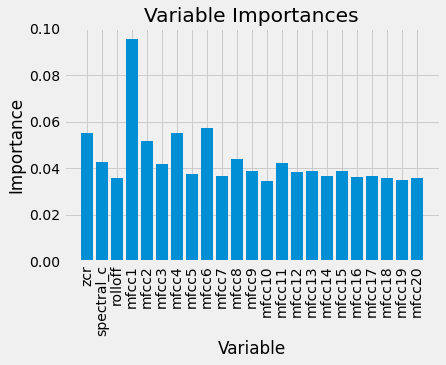

In [45]:
plt.style.use('fivethirtyeight')

importances = list(rf.feature_importances_)

x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, df[column_names], rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')

In [47]:
a = sorted(importances)
Best_importances = a[-10:]
Index_best_features = []
best_features = []

for i in Best_importances :
  for j in range(len(importances)) : 
    if i == importances[j] :
      Index_best_features.append(j)

#Index_best_features

for i in Index_best_features : 
  best_features.append(column_names[i])

best_features

['mfcc9',
 'mfcc3',
 'mfcc11',
 'spectral_c',
 'mfcc8',
 'mfcc2',
 'mfcc4',
 'zcr',
 'mfcc6',
 'mfcc1']

In [62]:
X_best_features = np.array(df[best_features])#features 
y = np.array(df['Emotions'])#label

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, test_size = 0.2)

In [57]:
# création du modèle
rf1 = RandomForestClassifier(n_estimators=4000, max_features='sqrt', max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True, criterion='gini' ,random_state=0)

# fit le modèle
rf1.fit(X_train_new ,y_train_new)



RandomForestClassifier(max_depth=20, max_features='sqrt', n_estimators=4000,
                       random_state=0)

In [63]:
# prédictions
predictions = rf1.predict(X_test_new)

# Zero_one_loss error
errors = zero_one_loss(y_test_new, predictions, normalize=False)
print('zero_one_loss error :', errors)

# Accuracy Score
accuracy_test = rf1.score(X_test_new, y_test_new)
print('accuracy_score on test dataset :', accuracy_test)

print(classification_report(predictions, y_test_new))

zero_one_loss error : 182
accuracy_score on test dataset : 0.8777703156480859
              precision    recall  f1-score   support

       angry       0.94      0.89      0.92       280
     disgust       0.86      0.88      0.87       253
        fear       0.85      0.90      0.88       241
       happy       0.84      0.90      0.87       248
     neutral       0.87      0.82      0.85       226
         sad       0.90      0.85      0.88       241

    accuracy                           0.88      1489
   macro avg       0.88      0.88      0.88      1489
weighted avg       0.88      0.88      0.88      1489



## CNN

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.Sequential(layers=[
        keras.layers.InputLayer(input_shape=features[0].shape),
        keras.layers.Conv2D(16, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(32, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(1, activation=keras.activations.sigmoid)
    ])
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.binary_crossentropy, metrics=['accuracy'])
print(model.summary())